In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
! pip3 install xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error


In [137]:
data = pd.read_csv('Data/dataset_mood_smartphone.csv')
print(len(data))
data.head()

376912


,Unnamed: 0,id,time,variable,value
0,1,AS14.01,2014-02-26 13:00:00.000,mood,6.0
1,2,AS14.01,2014-02-26 15:00:00.000,mood,6.0
2,3,AS14.01,2014-02-26 18:00:00.000,mood,6.0
3,4,AS14.01,2014-02-26 21:00:00.000,mood,7.0
4,5,AS14.01,2014-02-27 09:00:00.000,mood,6.0


In [4]:
print("There are {} users in this dataset".format(len(data["id"].unique())))
print("Tere are {} variables in this dataset and these variables are {}".format(len(data["variable"].unique()), data["variable"].unique()))
users = data["id"].unique()
average_num_of_timesteps = np.mean([len(data[data["id"]==user]) for user in users])
print("The average num of timesteps per user is {:.6}".format(average_num_of_timesteps))


There are 27 users in this dataset
Tere are 19 variables in this dataset and these variables are ['mood' 'circumplex.arousal' 'circumplex.valence' 'activity' 'screen'
 'call' 'sms' 'appCat.builtin' 'appCat.communication'
 'appCat.entertainment' 'appCat.finance' 'appCat.game' 'appCat.office'
 'appCat.other' 'appCat.social' 'appCat.travel' 'appCat.unknown'
 'appCat.utilities' 'appCat.weather']
The average num of timesteps per user is 13959.7


Average mood is 6.993 with std of 1.033


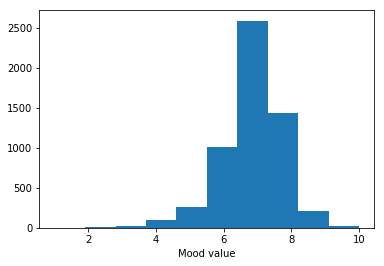

In [5]:
mood_values = data[data["variable"]=="mood"]["value"]
print("Average mood is {:.4} with std of {:.4}".format(np.mean(mood_values), np.std(mood_values)))
plt.hist(mood_values)
plt.xlabel("Mood value")
plt.show()

Average mood per user is 6.995 with std of 0.377


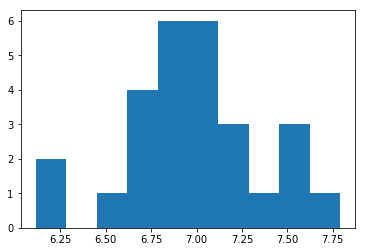

In [6]:
mood_values_per_user = data[data["variable"]=="mood"].groupby(by="id")['value'].mean()
print("Average mood per user is {:.4} with std of {:.4}".format(np.mean(mood_values_per_user), np.std(mood_values_per_user)))
plt.hist(mood_values_per_user)
plt.show()



In [8]:
#helper function to compare two dates, obsolete

def slice(datum, x = 10):
    return datum[:x]

def get_date_data_frame(data):
    return pd.DataFrame(list(map(slice , data["time"])))

dates = get_date_data_frame(data)[:2]
bigger_date = compare_two_dates(dates.iloc(0)[0][0], dates.iloc(1)[0][0])
print(bigger_date)



same


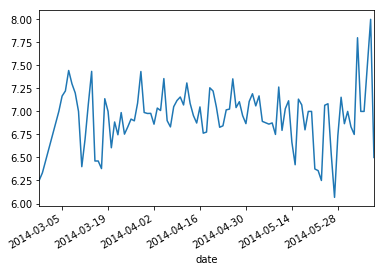

In [138]:
#getting dates and setting them as indexis
data["date"] = get_date_data_frame(data)
data['date'] = pd.to_datetime(data['date'])
data= data.set_index(['id', 'date'])

data[data['variable']=='mood']['value'].groupby(level = 'date').mean().plot()
plt.show()

Features to investigate and how to aggregate. <br />
Mood = average per day, average for t days <br /> circumplex.arousal = average<br /> circumplex.valence = average <br />
activity = average per day <br />
screen = sum per day,  average along several days, sum along days <br />
call = sum per day, average along several days, sum along days <br />
sms = sum per day, average along several days, sum along days <br />
for each in ['appCat.builtin' 'appCat.communication'
 'appCat.entertainment' 'appCat.finance' 'appCat.game' 'appCat.office'
 'appCat.other' 'appCat.social' 'appCat.travel' 'appCat.unknown'
 'appCat.utilities' 'appCat.weather']:
 sum per day.  <br />
 
 Also days which are closer to t can be scored higher
 

In [139]:
variables = data['variable'].unique()
#generating new df
date_data = pd.DataFrame(index = data.index)
sum_variables =  [ 'screen',
 'call', 'sms' ,'appCat.builtin', 'appCat.communication',
 'appCat.entertainment', 'appCat.finance', 'appCat.game' ,'appCat.office',
 'appCat.other', 'appCat.social', 'appCat.travel' ,'appCat.unknown',
 'appCat.utilities' ,'appCat.weather']
mean_variables = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity']
#grouping by id and date. creating a column for value for that day with either mean or sum (described in markdown)
for variable in variables:
    if variable in sum_variables:
        date_data[variable] = data[data['variable']==variable].groupby(level = ['id', 'date'])['value'].sum()#.reset_index(level=['id']).resample('D').sum()
    elif variable in mean_variables:
        date_data[variable] = data[data['variable']==variable].groupby(level = ['id', 'date'])['value'].mean()#.reset_index(level=['id']).resample('D').mean()
#target at day is the same as mood at day
date_data['target'] =date_data['mood']
#droping duplicates
date_data.drop_duplicates( keep='first', inplace=True)
#filling missing values were NaN means 0
values0 = {key: 0 for key in sum_variables}
date_data.fillna(value=values0, inplace=True)
#to do : think about values he didn't fill yet. although we have xgboost, so shouldn't be a problem
#rolling mean
lag = 5
rolling_variables  = date_data.columns
for variable in rolling_variables:
    date_data["{}_lagged".format(variable)]=date_data[variable].rolling(window = lag).mean()

In [140]:
#creating variables to drop
list_var = list(rolling_variables)
list_var.remove('target')
#fill target   MSE: 0.2652, don't think it's valid
#date_data['target'].fillna(method = "ffill", inplace=1)

# drop nan target MSE: 0.3179
#133 nan targets

date_data.dropna(axis = 0,subset = ["target"], inplace=1)


feature_data = np.array(date_data.reset_index(level='id').drop(axis=1, labels='id').drop(axis=1, labels = list_var))
x, y =feature_data[:,1:], feature_data[:,0]

seed = 42
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
model = XGBRegressor()
model.fit(X_train, y_train)

[15:07:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [141]:
y_pred = model.predict(X_test)
predictions = [value for value in y_pred]
#print(y_test, predictions)
accuracy = mean_squared_error(y_test, predictions)
print("MSE: {:.4}" .format(accuracy))

MSE: 0.3179


In [151]:
#baseline  MSE: 0.5868
baseline_vector = []
for i, m in enumerate(date_data['mood']):
    if i==0:
        continue
    baseline_vector.append(date_data['mood'].iloc[i-1])

x, y =np.array(baseline_vector).reshape(-1,1) , np.array(date_data['mood']).reshape(-1,1)

accuracy = mean_squared_error(y[1:], x)
print("MSE: {:.4}" .format(accuracy))

MSE: 0.5868


1259
